# <font color='red'> <b> <center> TRANSFORMER </center> </b> </font>

## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Sine and Cosine Angles](#1-1)
        - [Exercise 1 - get_angles](#ex-1)
    - [1.2 - Sine and Cosine Positional Encodings](#1-2)
        - [Exercise 2 - positional_encoding](#ex-2)
- [2 - Masking](#2)
    - [2.1 - Padding Mask](#2-1)
    - [2.2 - Look-ahead Mask](#2-2)
- [3 - Self-Attention](#3)
    - [Exercise 3 - scaled_dot_product_attention](#ex-3)
- [4 - Encoder](#4)
    - [4.1 Encoder Layer](#4-1)
        - [Exercise 4 - EncoderLayer](#ex-4)
    - [4.2 - Full Encoder](#4-2)
        - [Exercise 5 - Encoder](#ex-5)
- [5 - Decoder](#5)
    - [5.1 - Decoder Layer](#5-1)
        - [Exercise 6 - DecoderLayer](#ex-6)
    - [5.2 - Full Decoder](#5-2)
        - [Exercise 7 - Decoder](#ex-7)
- [6 - Transformer](#6)
    - [Exercise 8 - Transformer](#ex-8)
- [7 - References](#7)

<a name="1"></a>
## <font color='red'> <b>  1. Intro </b> </font>

This notebook is dedicated to implementing a Transformer model from scratch, following the architecture described in the groundbreaking paper "Attention Is All You Need" by Vaswani et al. The primary objective of this implementation is to learn and understand the inner workings of Transformers, rather than simply using prebuilt libraries.

I am going to cover key components such as:

- Positional Encoding: Injecting order into sequences.
- Scaled Dot-Product Attention: The core mechanism behind attention.
- Multi-Head Attention: Learning diverse relationships in data.
- Feed-Forward Networks: Extending attention's capabilities.
- Layer Normalization and Residual Connections: Stabilizing and enhancing learning.
- Encoder-Decoder Structure: Processing input and generating output.

By the end of this notebook, you should gain a conceptual understanding of each component and how they fit together to form the Transformer. This hands-on approach will help demystify the architecture and prepare you to adapt or experiment with it for your own projects.

<a name="2"></a>
## <font color='red'> <b>  2. Setup </b> </font>

In [2]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

In [60]:
# Set the print options
np.set_printoptions(precision=3)

<a name="3"></a>
## <font color='red'> <b>  3. Positional Encoding </b> </font>

<a name="3.1"></a>
### <font color='orange'> <b> 3.1. Concept and motivation </b> </font>


In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network.


There are various types of positional encoding, for example:

- Sinusoidal encoding
- Learned Positional Encoding
- Relative Positional encoding


In this notebook I will use the sinusoidal encoding, given by the following formulas:

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{n}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{n}^{\frac{2i}{d}}}\right)
\tag{2}$$


where:

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.
* $n$ is a user defined scalar (10000 in the paper)


The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. 

In this notebook I am going to use horizontal vectors, that's why all the matrix multiplications should be adjusted accordingly.

Let’s clarify the **number of positions in the sequence** with an example.


Imagine you have a sequence of words:
["The", "cat", "sat", "on", "the", "mat"].

Here:

- Each word in the sequence corresponds to a position.
- The total number of positions is the number of words in the sequence, which is 6 in this case.

Now, if you're embedding these words (e.g., using word embeddings), you might represent the sequence as a matrix where:

- Rows correspond to positions in the sequence (one row for each word).
- Columns correspond to the embedding dimensions (let’s assume d=4 for simplicity).


<a name="3.2"></a>
### <font color='orange'> <b> 3.2. Implementation </b> </font>

In [3]:
# helper function: get the angles for the positional encoding
def get_angles(pos, i, d, n=10000):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
        n -- user defined scalar
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    angles = pos/ (np.power(n, (2 * (i//2)) / np.float32(d)))

    
    return angles

In [4]:
# NOTE
for i in range(4):
    print(f"If i = {i} -> i//2 = {i//2}")

If i = 0 -> i//2 = 0
If i = 1 -> i//2 = 0
If i = 2 -> i//2 = 1
If i = 3 -> i//2 = 1


Let's try our function.

First let's remember that we can use np.newaxis to add an extra dimension to a numpy array.

For example, in np.arange(7)[:, np.newaxis], [:, np.newaxis] adds a new axis (dimension) to the array along the columns, essentially converting the 1D array into a 2D column vector.

In the case of np.arange(3)[np.newaxis, :], the new axis is added along the rows, resulting in a row vector.


In [5]:
np.arange(7).shape, np.arange(7)[:, np.newaxis].shape, np.arange(3).shape,  np.arange(3)[np.newaxis, :].shape

((7,), (7, 1), (3,), (1, 3))

In [6]:
np.arange(7), np.arange(7)[:, np.newaxis]

(array([0, 1, 2, 3, 4, 5, 6]),
 array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6]]))

In [7]:
np.arange(3), np.arange(3)[np.newaxis, :]

(array([0, 1, 2]), array([[0, 1, 2]]))

In [8]:
example = get_angles(np.arange(7)[:, np.newaxis], np.arange(3)[np.newaxis, :], 4)
print(example.shape)
example

(7, 3)


array([[0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.01],
       [2.  , 2.  , 0.02],
       [3.  , 3.  , 0.03],
       [4.  , 4.  , 0.04],
       [5.  , 5.  , 0.05],
       [6.  , 6.  , 0.06]])

Now, let's implement the positional encoding. We have to use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

In [9]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis,:],
                            d)
      
    # -> angle_rads has dim (positions,d)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # #  add an extra dimension at the beginning of the array, 
    # so the final shape of pos_encoding becomes (1, positions, d)
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

**Note.**. Let's talk a little bit more about the line "pos_encoding = angle_rads[np.newaxis, ...]". The purpose of np.newaxis is to add an extra dimension at the beginning of the array, so the final shape of pos_encoding becomes (1, positions, d). This means the positional encoding has an additional dimension at the start, representing a "batch" of size 1 (this is typical in TensorFlow and other deep learning frameworks).

For example, if positions = 3 and d = 4, the shape of pos_encoding will be (1, 3, 4).

- 1 represents the batch size (in this case, just one sequence set).
- 3 is the number of positions in the sequence.
- 4 is the size of the embedding vectors.

To retrieve the positional encoding for the positions, you can take pos_encoding[0], which selects the matrix with dimensions (3, 4). This is the positional encoding to be added to your input embeddings, representing the application of positional encoding to your input sequence.

Let's try our function.

In [10]:
# 8 positions with an embedding size of 3
example = positional_encoding(8, 3)
example

<tf.Tensor: shape=(1, 8, 3), dtype=float32, numpy=
array([[[ 0.        ,  1.        ,  0.        ],
        [ 0.84147096,  0.5403023 ,  0.00215443],
        [ 0.9092974 , -0.41614684,  0.00430886],
        [ 0.14112   , -0.9899925 ,  0.00646326],
        [-0.7568025 , -0.6536436 ,  0.00861763],
        [-0.9589243 ,  0.2836622 ,  0.01077196],
        [-0.2794155 ,  0.96017027,  0.01292625],
        [ 0.6569866 ,  0.75390226,  0.01508047]]], dtype=float32)>

In [11]:
example[0]

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[ 0.        ,  1.        ,  0.        ],
       [ 0.84147096,  0.5403023 ,  0.00215443],
       [ 0.9092974 , -0.41614684,  0.00430886],
       [ 0.14112   , -0.9899925 ,  0.00646326],
       [-0.7568025 , -0.6536436 ,  0.00861763],
       [-0.9589243 ,  0.2836622 ,  0.01077196],
       [-0.2794155 ,  0.96017027,  0.01292625],
       [ 0.6569866 ,  0.75390226,  0.01508047]], dtype=float32)>

Let's plot our positional encodings.

(1, 50, 512)


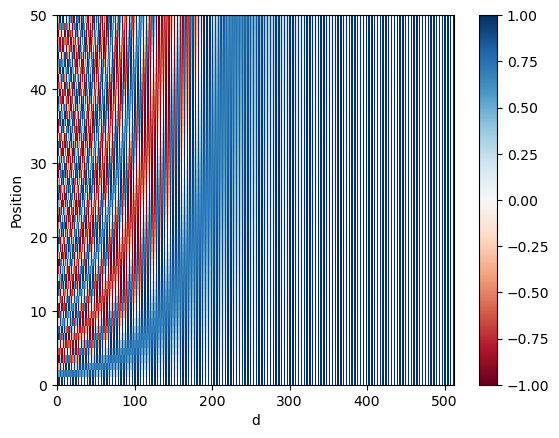

In [12]:
num_positions = 50
d = 512

pos_encoding = positional_encoding(num_positions, d)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu') # we take pos_encoding[0] (we remove batch dimension)
plt.xlabel('d')
plt.xlim((0, d))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row represents a positional encoding - notice how none of the rows are identical! We have created a unique positional encoding for each of the words.

Finally, let's look at an example where we add the positional encoding to the word embeddings.

<img src="images/PosEncoding.png"/>

In [13]:
# Let' say that we have an embedding with 3 tokens and 4 dimensions


# input text: "I am happy"
embedding = np.array([[0.1, 0.2, 0.3, 0.4], # corresponds to "I"
                     [0.5, 0.6, 0.7, 0.8],  # corresponds to "am"
                     [0.9, 1.0, 1.1, 1.2]]) # corresponds to "happy"

embedding = tf.constant(embedding, dtype=tf.float32)

# Positional encoding for a sequence of length 3 and embedding size 4
pos_encoding = positional_encoding(3, 4)

# sum of embedding with positional encoding
encoded_input = embedding + pos_encoding[0]

# Results
print("\033[1mInput embedding:\033[0m")
print(embedding)

print("\033[1m\nPositional Encoding:\033[0m")
print(pos_encoding)

print("\033[1m\nSum of the embedding with positional encoding:\033[0m")
print(encoded_input)


Input embedding:
tf.Tensor(
[[0.1 0.2 0.3 0.4]
 [0.5 0.6 0.7 0.8]
 [0.9 1.  1.1 1.2]], shape=(3, 4), dtype=float32)

Positional Encoding:
tf.Tensor(
[[[ 0.          1.          0.          1.        ]
  [ 0.84147096  0.5403023   0.00999983  0.99995   ]
  [ 0.9092974  -0.41614684  0.01999867  0.9998    ]]], shape=(1, 3, 4), dtype=float32)

Sum of the embedding with positional encoding:
tf.Tensor(
[[0.1       1.2       0.3       1.4      ]
 [1.341471  1.1403023 0.7099998 1.79995  ]
 [1.8092973 0.5838531 1.1199987 2.1998   ]], shape=(3, 4), dtype=float32)


<a name="4"></a>
## <font color='red'> <b>  4. Masking </b> </font>

There are two types of masks that are useful when building your Transformer network: 

- The *padding mask*
- The *look-ahead mask*

Both help the softmax computation give the appropriate weights to the words in your input sentence. 

<a name="4.1"></a>
### <font color='orange'> <b> 4.1. Padding mask </b> </font>

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by a small negative number (for example -1e9) and adding it to your sequence, you mask out the zeros by setting them to close to negative infinity.

After masking, your input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when you take the softmax, the zeros don't affect the score.

Let's remember that in in a softmax function, when x approach to -infinity, the value tends to 0.

<img src="images/softmax.png"/>

We will use [tf.math.equal](https://www.tensorflow.org/api_docs/python/tf/math/equal)

In [66]:
# Example sequence
seq = tf.constant([[1, 0, 3], [4, 0, 6]])
print(f"Original data:\n {seq}")

# Check where elements are equal to 0
mask = tf.math.equal(seq, 0)  # Result: [[False, True, False], [False, True, False]]
print(f"\n Mask:\n {mask}")

# Convert to float32
mask_float = tf.cast(mask, tf.float32)  # Result: [[0.0, 1.0, 0.0], [0.0, 1.0, 0.0]]

print(f"\n Mask Float:\n {mask_float}")

Original data:
 [[1 0 3]
 [4 0 6]]

 Mask:
 [[False  True False]
 [False  True False]]

 Mask Float:
 [[0. 1. 0.]
 [0. 1. 0.]]


In [42]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :] # shape (n, 1, 1, m)

In [43]:
# Let's try our function

x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


We can see that in every place where there was a number other than 0, it was changed to 0, and in the places where there was a 1, it was changed to 1.

Let's multiply this by a small number (1e-9 in this example):

In [44]:
create_padding_mask(x) * -1.0e9

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[-0.e+00, -0.e+00, -1.e+09, -1.e+09, -0.e+00]]],


       [[[-0.e+00, -0.e+00, -0.e+00, -1.e+09, -1.e+09]]],


       [[[-1.e+09, -1.e+09, -1.e+09, -0.e+00, -0.e+00]]]], dtype=float32)>

We will now see that the difference between the softmax of x and that of x added to this mask is very small.

In [51]:
tf.keras.activations.softmax(x) 

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[7.288e-01, 2.681e-01, 6.645e-04, 6.645e-04, 1.806e-03],
       [8.444e-02, 2.295e-01, 6.239e-01, 3.106e-02, 3.106e-02],
       [4.854e-03, 4.854e-03, 4.854e-03, 2.650e-01, 7.204e-01]],
      dtype=float32)>

In [59]:
tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9, axis=-1)

<tf.Tensor: shape=(3, 1, 3, 5), dtype=float32, numpy=
array([[[[0.09 , 0.245, 0.665, 0.   , 0.   ],
         [0.016, 0.117, 0.867, 0.   , 0.   ],
         [0.844, 0.114, 0.042, 0.   , 0.   ]]],


       [[[0.   , 0.259, 0.705, 0.035, 0.   ],
         [0.   , 0.114, 0.844, 0.042, 0.   ],
         [0.   , 0.576, 0.212, 0.212, 0.   ]]],


       [[[0.245, 0.665, 0.   , 0.   , 0.09 ],
         [0.107, 0.787, 0.   , 0.   , 0.107],
         [0.665, 0.09 , 0.   , 0.   , 0.245]]]], dtype=float32)>

**Summary**

- Padding Mask
    - A mask that indicates which elements in the sequence are padding and which are not.
- Usage in Attention.
    - It ensures that padding values do not affect the attention scores and, therefore, the result of the softmax.
- Effect: 
    - Padding values do not influence the calculation of the output representations, allowing the model to focus only on the relevant parts of the sequence.
This is crucial for proper training and for preventing the model from being "confused" by the artificially added zeros.

<a name="4.2"></a>
### <font color='orange'> <b> 4.2. Look-ahead mask </b> </font>

The look-ahead mask (or causal mask) is a special type of mask used in the Transformer, especially in the context of the decoder. Its main function is to prevent the model from using future information when predicting the next word or token in a sequence, ensuring that the model is autoregressive.

Why is it used? The purpose of the look-ahead mask is to prevent the model from seeing the future when generating an output sequence. This means that when the model is predicting the token at position i, it should not "see" tokens at later positions (i+1, i+2, ...). This is crucial during both training and inference because, during inference, the model does not have access to future sequence information.

How does it work? The look-ahead mask is a lower triangular matrix (with 1s in the lower part and 0s in the upper part), which is applied to the attention scores. This mask ensures that the attention values corresponding to future tokens in the sequence are masked.

During the attention calculation, the attention scores for elements at future positions are set to a very negative value (e.g., negative infinity), so that after applying softmax, these positions do not influence the probability calculation.

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

For the implementation we will use [tf.linalg.band_part](https://www.tensorflow.org/api_docs/python/tf/linalg/band_part).

More specifically:

tf.linalg.band_part(matrix, -1, 0):

This is a function that extracts the lower triangular part of a matrix, with the specific options given:

- matrix: The matrix to extract from, which is the matrix of ones in this case.

- -1: The number of diagonals to include below the main diagonal. A value of -1 means all diagonals below the main diagonal.

- 0: The number of diagonals to include above the main diagonal. A value of 0 means no diagonals above the main diagonal are included.

So, it creates a lower triangular matrix, meaning it keeps the elements below and on the main diagonal, and sets all the elements above the main diagonal to 0.

In [67]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

In [70]:
# Let's try
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])

temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

**Summary**

- Look-ahead mask: 
    - A mask used in the decoder to prevent the model from seeing future tokens when making predictions in a sequence. 

- Purpose: 
    - Ensure that the model is autoregressive and generates tokens in sequential order, without accessing future information.

<a name="5"></a>
## <font color='red'> <b>  5. Attention</b> </font>

<a name="5.1"></a>
### <font color='orange'> <b> 5.1. Types of Attention </b> </font>

The 3 main types of attention in the transformer model are:

- Encoder-decoder attention.
- Self-Attention
- Masked Self-Attention

### The 3 Main Types of Attention in the Transformer Model:

1. **Encoder-Decoder Attention**:
   - This occurs in the decoder and allows the decoder to attend to all positions in the encoder's output. 
   - It is crucial for tasks like translation, where the decoder generates words based on the source sentence encoded by the encoder.

2. **Self-Attention**:
   - Used in both the encoder and decoder.
   - Each token in the input sequence attends to all other tokens in the same sequence, enabling the model to capture dependencies between words.

3. **Masked Self-Attention**:
   - A variation of self-attention, used in the decoder.
   - It prevents the decoder from attending to future tokens (positions ahead of the current token) during training.
   - This is achieved by applying a look-ahead mask to the attention mechanism.


### Encoder decoder-attention

### Scaled dot-product attention

In scale dot-products attention:

- We have queries, keys and values.
- The attention layer outputs context vectors for each query.
     - The context vectors are weighted sums of the values where the similarity between the queries and keys determines the weights assigned to each value.
- The softmax ensures that the weights add up to 1.
- The division by the square roots of the dimension of the key factors is used to improve performance.


Mathematically:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode.


The scale dot-product attention mechanism is very efficient since it relies only on matrix multiplication and a softmax. Additionally, we can implement this attention mechanism to run on GPUs or TPUs to speed up training.


To get the query, key and value matrices, you must first transform the words in your sequences toward embeddings.

- Let 's take the sentence "Soy feliz" as the source for the queries. 
    - You'll need to get the embedding vector for the words "Soy" and "feliz".
    - The query matrix will contain all of these embedding vectors as rows.
    - The matrix size is given by the size of the word embeddings and the length of the sequence. 
        - If the word embbedimgs size is for example d=4, then, in this example, the size will be 4x2 (because the length of our sequence ("Soy feliz") is 2).
- To get the key matrix, let's use the sentence “I am happy”. You will get the embedding for each word in the sentence and stack them together to form the key matrix.
    - The size will be: sequence length of the keys x dimension of the embedding (3 x 4 in this example).

You will generally use the same vectors used for the key matrix for the value matrix. But you could also transform them first.

Note that the number of vectors used to form the key and value matrix must be the same. 





<img src="images/scaled_dot_product.png"/>

Now, we can implement the formula.

- First, you compute the matrix products between the query and the transpose of the key matrix. You scale it by the inverse of the square of the dimension of the key vectors, dk and calculate the softmax. 
    - This computation will give you a matrix with the weights for each key per query. Therefore the weight matrix will have a total number of elements equal to the number of queries times the number of keys.
        - For example, the third element in the second row would correspond to the weights assigned to the third key for the second query.
- After the computation of the weights matrix, you can multiply it with the value matrix to get a matrix that has rows and the context vector corresponding to each query. 
    - The number of columns on this matrix is equal to the size of the value vectors, which is often the same as the embedding size.



<img src="images/math_scd.png"/>

In [78]:
def scaled_dot_product_attention_v0(q, k, v):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)

    Returns:
        output -- attention_weights
    """
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)
    
    return output, attention_weights

**Note.** About the ellipsis in the docstring.

The ... (ellipsis) represents the batch dimensions and any additional dimensions (e.g., for multi-head attention or hierarchical models). In simpler cases, this is just the batch size. For example:

- In a single-head attention scenario, the shape might be (batch_size,).
- In a multi-head attention scenario, the shape might be (batch_size, num_heads).



In [79]:
# Example: Query, Key, Value tensors
batch_size = 2  # Number of sequences in the batch
seq_len_q = 3   # Length of the query sequence
seq_len_kv = 4  # Length of the key and value sequences
depth = 5       # Embedding size for query/key
depth_v = 6     # Embedding size for value

# Generate random tensors for q, k, v
q = tf.random.uniform((batch_size, seq_len_q, depth))   # Shape: (2, 3, 5)
k = tf.random.uniform((batch_size, seq_len_kv, depth))  # Shape: (2, 4, 5)
v = tf.random.uniform((batch_size, seq_len_kv, depth_v))  # Shape: (2, 4, 6)

# Apply scaled dot-product attention
output, attention_weights = scaled_dot_product_attention_v0(q, k, v)

# Print shapes and results
print("\033[1mQuery shape:\033[0m", q.shape)
print("\033[1mKey shape:\033[0m", k.shape)
print("\033[1mValue shape:\033[0m", v.shape)
print("\033[1mOutput shape:\033[0m", output.shape)  # Should match (batch_size, seq_len_q, depth_v)
print("\033[1mAttention weights shape:\033[0m", attention_weights.shape)  # Should match (batch_size, seq_len_q, seq_len_kv)

# Print the tensors (optional)
print("\n\033[1mAttention Weights:\033[0m\n", attention_weights)
print("\n\033[1mOutput:\033[0m\n", output)


Query shape: (2, 3, 5)
Key shape: (2, 4, 5)
Value shape: (2, 4, 6)
Output shape: (2, 3, 6)
Attention weights shape: (2, 3, 4)

Attention Weights:
 tf.Tensor(
[[[0.273 0.215 0.305 0.207]
  [0.258 0.219 0.284 0.239]
  [0.246 0.23  0.282 0.242]]

 [[0.215 0.239 0.25  0.296]
  [0.227 0.24  0.249 0.283]
  [0.239 0.228 0.224 0.309]]], shape=(2, 3, 4), dtype=float32)

Output:
 tf.Tensor(
[[[0.49  0.527 0.654 0.747 0.213 0.49 ]
  [0.465 0.527 0.631 0.751 0.219 0.489]
  [0.454 0.527 0.629 0.746 0.219 0.489]]

 [[0.273 0.125 0.413 0.323 0.479 0.443]
  [0.273 0.124 0.415 0.334 0.487 0.438]
  [0.287 0.117 0.431 0.336 0.494 0.438]]], shape=(2, 3, 6), dtype=float32)


Now, let's generalize the previous function to include an optional mask that will allow us to implement masked self-attention.

Mathematicaly:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode.


<img src="images/math_scdt_mask.png"/>

In [81]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)

    return output, attention_weights

In [82]:
# Example: Query, Key, Value tensors and Mask
batch_size = 2  # Number of sequences in the batch
seq_len_q = 3   # Length of the query sequence
seq_len_kv = 4  # Length of the key and value sequences
depth = 5       # Embedding size for query/key
depth_v = 6     # Embedding size for value

# Generate random tensors for q, k, v
q = tf.random.uniform((batch_size, seq_len_q, depth))   # Shape: (2, 3, 5)
k = tf.random.uniform((batch_size, seq_len_kv, depth))  # Shape: (2, 4, 5)
v = tf.random.uniform((batch_size, seq_len_kv, depth_v))  # Shape: (2, 4, 6)

# Generate a mask (e.g., padding mask)
mask = tf.constant([[0, 0, 0, 1], [0, 1, 0, 0]], dtype=tf.float32)  # Shape: (2, 4)
mask = tf.reshape(mask, (batch_size, 1, 1, seq_len_kv))  # Reshape to broadcast shape

# Apply scaled dot-product attention with masking
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)

# Print shapes and results
print("\033[1mQuery shape:\033[0m", q.shape)
print("\033[1mKey shape:\033[0m", k.shape)
print("\033[1mValue shape:\033[0m", v.shape)
print("\033[1mMask shape:\033[0m", mask.shape)
print("\033[1mOutput shape:\033[0m", output.shape)  # Should match (batch_size, seq_len_q, depth_v)
print("\033[1mAttention weights shape:\033[0m", attention_weights.shape)  # Should match (batch_size, seq_len_q, seq_len_kv)

# Print the tensors (optional)
print("\n\033[1mAttention Weights:\033[0m\n", attention_weights)
print("\n\033[1mOutput:\033[0m\n", output)

Query shape: (2, 3, 5)
Key shape: (2, 4, 5)
Value shape: (2, 4, 6)
Mask shape: (2, 1, 1, 4)
Output shape: (2, 2, 3, 6)
Attention weights shape: (2, 2, 3, 4)

Attention Weights:
 tf.Tensor(
[[[[0.346 0.309 0.345 0.   ]
   [0.332 0.312 0.356 0.   ]
   [0.331 0.292 0.376 0.   ]]

  [[0.358 0.306 0.336 0.   ]
   [0.35  0.324 0.326 0.   ]
   [0.32  0.352 0.328 0.   ]]]


 [[[0.332 0.    0.331 0.337]
   [0.313 0.    0.336 0.352]
   [0.318 0.    0.361 0.322]]

  [[0.357 0.    0.335 0.309]
   [0.355 0.    0.331 0.315]
   [0.362 0.    0.371 0.266]]]], shape=(2, 2, 3, 4), dtype=float32)

Output:
 tf.Tensor(
[[[[0.507 0.418 0.349 0.552 0.775 0.377]
   [0.513 0.416 0.35  0.547 0.77  0.371]
   [0.502 0.421 0.334 0.543 0.762 0.366]]

  [[0.67  0.493 0.661 0.743 0.67  0.357]
   [0.671 0.485 0.662 0.736 0.678 0.35 ]
   [0.683 0.472 0.665 0.725 0.687 0.336]]]


 [[[0.361 0.411 0.183 0.57  0.739 0.426]
   [0.367 0.406 0.184 0.567 0.735 0.422]
   [0.363 0.414 0.177 0.561 0.728 0.413]]

  [[0.74  0.433 0.

<a name='3'></a>
## 3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode
    
    
   
    
    <font color='red'> poner las dimensiones de las matrices y la foto  </font>
    

<a name='ex-3'></a>
### Exercise 3 - scaled_dot_product_attention 

    Implement the function `scaled_dot_product_attention()` to create attention-based representations
**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. Multiply it by -1e9 before applying the softmax. 


Cuando en la documentación de TensorFlow o NumPy ves algo como (..., seq_len, depth), no es un caso específico de indexación, sino una convención para describir tensores. En este contexto:

La elipsis ... indica que puede haber dimensiones adicionales antes de seq_len y depth.
Por ejemplo:
(..., seq_len, depth) podría representar batch_size x num_heads x seq_len x depth si hay dimensiones de batch y de atención multi-cabeza.


In [21]:
def scaled_dot_product_attention(q, k, v, mask, verbose=False): # verbose
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)
    
    #
    if verbose:
        print(matmul_qk)
        print(dk)
        print(scaled_attention_logits)
        print(attention_weights)
        print(output)
    

    return output, attention_weights

In [22]:
# Define parámetros de prueba
batch_size = 2
seq_len_q = 4
seq_len_k = 4
depth = 8
depth_v = 16

# Generar datos aleatorios para q, k y v
q = tf.random.uniform((batch_size, seq_len_q, depth), dtype=tf.float32)
k = tf.random.uniform((batch_size, seq_len_k, depth), dtype=tf.float32)
v = tf.random.uniform((batch_size, seq_len_k, depth_v), dtype=tf.float32)

# Crear una máscara de ejemplo (por ejemplo, para una máscara de atención futura)
mask = tf.linalg.band_part(tf.ones((seq_len_q, seq_len_k)), -1, 0)  # Triangular inferior
mask = tf.expand_dims(mask, axis=0)  # Agregar dimensión batch
mask = tf.cast(mask, dtype=tf.float32)  # Asegurar que sea flotante

# Activar modo verbose
verbose = True


# Ejecutar prueba
output, attention_weights = scaled_dot_product_attention(q, k, v, mask, verbose=verbose)

# Imprimir formas de salida para confirmar
print("\nSalida:")
print("output shape:", output.shape)
print("attention_weights shape:", attention_weights.shape)

tf.Tensor(
[[[2.279387   1.825793   0.63186634 1.8834672 ]
  [2.052302   1.8852794  1.0053144  1.7148666 ]
  [3.4180002  3.1079035  1.5024791  2.8961418 ]
  [2.9149811  2.2005377  1.0817361  2.4234016 ]]

 [[2.116521   1.5778772  2.4985871  1.7644594 ]
  [1.5468688  2.1394327  2.2381554  1.2607064 ]
  [2.2123241  1.8038421  2.423389   1.9076121 ]
  [1.1489832  1.3651273  1.2714128  0.96710193]]], shape=(2, 4, 4), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(
[[[-1.0000000e+09  6.4551532e-01  2.2339849e-01  6.6590625e-01]
  [-1.0000000e+09 -1.0000000e+09  3.5543230e-01  6.0629690e-01]
  [-1.0000000e+09 -1.0000000e+09 -1.0000000e+09  1.0239408e+00]
  [-1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09]]

 [[-1.0000000e+09  5.5786383e-01  8.8338399e-01  6.2383062e-01]
  [-1.0000000e+09 -1.0000000e+09  7.9130745e-01  4.4572705e-01]
  [-1.0000000e+09 -1.0000000e+09 -1.0000000e+09  6.7444271e-01]
  [-1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09]]], 

q (query):

Forma: (..., seq_len_q, depth)
Representa el query o consulta en el mecanismo de atención.
Es un tensor que contiene las representaciones del input que queremos comparar con las keys (k).
seq_len_q es la longitud de la secuencia del query, y depth es la dimensionalidad de la representación.


k (key):

Forma: (..., seq_len_k, depth)
Representa las keys que se utilizan para calcular la similitud con el query.
seq_len_k es la longitud de la secuencia de las keys. Debe coincidir con la longitud de las values (v).
depth debe coincidir con la dimensión del query para permitir la multiplicación.


v (value):

Forma: (..., seq_len_v, depth_v)
Representa los valores asociados a las keys.
seq_len_v (longitud de la secuencia de valores) debe ser igual a seq_len_k, ya que cada key tiene un valor asociado.
depth_v es la dimensionalidad de cada valor. Puede ser diferente de depth.
mask:

Forma: Broadcastable a (..., seq_len_q, seq_len_k)
Es una máscara opcional que se aplica a las similitudes calculadas (logits) para ignorar ciertos elementos en la atención.
Tipos de máscaras:
Máscara de relleno: Se utiliza para ignorar tokens de relleno (padding) en secuencias más cortas.
Máscara de atención futura: Se utiliza en modelos como transformers para evitar que un token preste atención a tokens futuros.

Si tienes una secuencia de palabras de longitud 5 (seq_len_q=5) con representaciones de 8 dimensiones (depth=8), y estás usando un conjunto de keys y values de longitud 6 (seq_len_k=6 y seq_len_v=6), las formas serían:

q: (batch_size, 5, 8)
k: (batch_size, 6, 8)
v: (batch_size, 6, depth_v) (por ejemplo, depth_v=16).
mask: Broadcastable a (batch_size, 5, 6).
Esta flexibilidad permite que la función maneje diferentes longitudes de secuencia y dimensiones de representación según la arquitectura del modelo.

seq_len_q y seq_len_k
seq_len_q (Sequence Length of Query):

Es la longitud de la secuencia del query (q).
Representa cuántos tokens, palabras o elementos hay en la secuencia que queremos evaluar en términos de atención.
Ejemplo:
Si estás procesando una frase con 5 palabras como consulta, seq_len_q = 5.
seq_len_k (Sequence Length of Key/Value):

Es la longitud de la secuencia de las keys (k) y values (v).

Representa cuántos tokens, palabras o elementos están disponibles como contexto para la atención.

Regla importante: seq_len_k debe ser igual a seq_len_v, ya que cada key tiene un value asociado.

Ejemplo:

Si tienes una frase de 7 palabras como contexto, seq_len_k = 7 y seq_len_v = 7.

Elipsis (...):

Representa dimensiones adicionales opcionales al principio del tensor.
Permite trabajar con entradas que tienen diferentes niveles de jerarquía, como lotes de datos (batch) o niveles de anidación.
Ejemplo de forma (..., seq_len_q, depth):

Caso 1: Sin lotes (batch_size = 1):

Si procesas una sola secuencia, el tensor podría tener la forma (seq_len_q, depth).
Ejemplo: (5, 8) para 5 tokens con representaciones de 8 dimensiones cada uno.
Caso 2: Con lotes (batch_size = 2):

Para procesar múltiples secuencias en paralelo, ... puede ser el tamaño del lote.
Ejemplo: (batch_size, seq_len_q, depth) → (2, 5, 8).
Caso 3: Dimensiones más complejas:

Si trabajas con datos anidados o multi-modales, ... podría incluir más dimensiones adicionales.
Ejemplo: (num_heads, batch_size, seq_len_q, depth).

Supongamos que trabajamos con un modelo que analiza secuencias de texto en lotes:

Un lote tiene 2 secuencias.
Cada secuencia tiene:
4 palabras como query (seq_len_q=4).
6 palabras como contexto (seq_len_k=6).
Las representaciones tienen una dimensionalidad de 8 (depth=8).
Las formas de los tensores serían:

q: (2, 4, 8) → 2 secuencias, 4 palabras de query, 8 dimensiones.
k: (2, 6, 8) → 2 secuencias, 6 palabras de key, 8 dimensiones.
v: (2, 6, depth_v) (por ejemplo, depth_v=16) → Valores asociados a las keys.
Con esta estructura, la función calcula cómo cada palabra de las queries se relaciona con cada palabra de las keys, y luego aplica los pesos a los valores para generar la salida final.

## Multi-head attention

 you can think of as computing the self-attention several times to detect different features.
 
 
 ----------->>>> FOTO
 
 We will use the Keras implementation.

### masked multi-head attention

### Feed forward network

It will contain 2 Dense layers.

In [23]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

## Encoder


The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. You will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a). 
<img src="encoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</font></center></caption>

    

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.


### Encoder layer


Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training.

In this exercise, you will implement one encoder block (Figure 2) using the `call()` method. The function should perform the following steps: 
1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K should be the same.
2. Next, you will pass the output of the multi-head attention layer to a dropout layer. Don't forget to use the `training` parameter to set the mode of your model. 
3. Now add a skip connection by adding your original input `x` and the output of the dropout layer. 
4. After adding the skip connection, pass the output through the first layer normalization.
5. Finally, repeat steps 1-4 but with the feed forward neural network instead of the multi-head attention layer.

**Additional Hints**:
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`. 
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. *Note that if query, key and value are the same, then this function performs self-attention.*

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line)
        #-> To compute self-attention Q, V and K should be the same (x)
        self_attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        self_attn_output = self.dropout1(self_attn_output, training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        mult_attn_out = self.layernorm1(x + self_attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out

### Full encoder

Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embedd your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers. 

<img src="encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</font></center></caption>


<a name='ex-5'></a>
### Exercise 5 - Encoder

Complete the `Encoder()` function using the `call()` method to embed your input, add positional encoding, and implement multiple encoder layers 

In this exercise, you will initialize your Encoder with an Embedding layer, positional encoding, and multiple EncoderLayers. Your `call()` method will perform the following steps: 
1. Pass your input through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [27]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        

        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training, mask)


        return x  # (batch_size, input_seq_len, embedding_dim)

### Subclassing API

In [26]:
import tensorflow as tf

# Definimos una clase que hereda de tf.keras.Model
class SimpleLinearModel(tf.keras.Model):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        # Agregamos una capa completamente conectada con 1 unidad
        self.dense = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        # Implementamos el paso de inferencia del modelo
        return self.dense(inputs)

# Creamos una instancia del modelo
model = SimpleLinearModel()

# Datos de ejemplo
x = tf.constant([[1.0], [2.0], [3.0], [4.0]])
y = tf.constant([[2.0], [4.0], [6.0], [8.0]])

# Compilamos el modelo
model.compile(optimizer='sgd', loss='mse')

# Entrenamos el modelo
model.fit(x, y, epochs=5, verbose=0)

# Hacemos una predicción
predictions = model(tf.constant([[5.0]]))
print("Predicción para 5.0:", predictions.numpy())


Epoch 1/5
1/1 [==============================] - 0s 284ms/step - loss: 43.3206
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 30.0862
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 20.9029
Epoch 4/5
1/1 [==============================] - 0s 4ms/step - loss: 14.5307
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 10.1090
Predicción para 5.0: [[4.88076]]


class SimpleLinearModel(tf.keras.Model):

Define una subclase personalizada que hereda de tf.keras.Model.
Sirve para estructurar el modelo de forma más flexible.
self.dense = tf.keras.layers.Dense(units=1):

Creamos una capa densa con 1 unidad. Esto representa un modelo lineal.
Método call:

Es el método donde definimos cómo pasa la entrada a través del modelo (forward pass).
Entrenamiento y predicción:

El modelo funciona como cualquier otro modelo en Keras: lo compilamos, entrenamos y hacemos predicciones.

En el constructor (__init__):

Definimos las capas personalizadas o predefinidas que va a utilizar nuestro modelo.
Esto incluye capas de Keras como Dense, Conv2D, o incluso nuestras propias capas personalizadas.
En el método call:

Construimos la arquitectura del modelo, especificando cómo fluyen los datos a través de las capas.
Este método define el forward pass del modelo, es decir, cómo se transforma la entrada para producir la salida.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate logits for Category 1
logits = np.linspace(-10, 10, 100)  # Logits from -10 to 10
logits_matrix = np.stack([logits, np.zeros_like(logits), -logits], axis=1)  # Three categories

# Convert logits to a TensorFlow tensor
logits_tensor = tf.constant(logits_matrix, dtype=tf.float32)

# Compute the softmax
softmax_values = tf.nn.softmax(logits_tensor, axis=1).numpy()

# Plot the softmax for Category 1
plt.plot(logits, softmax_values[:, 0],  color="red")

# Add a vertical line at x=0
plt.axvline(x=0, color="orange")

# Add labels and title
plt.title("Softmax Function")
plt.xlabel("x")
plt.ylabel("y")
#plt.grid()
plt.legend()
plt.show()
